### Customer Satisfaction Prediction

In [113]:
import openml
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

In [114]:
# Configure Matplotlib/Seaborn for better plotting aesthetics
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [115]:
# --- 1. Data Loading ---
print("--- 1. Loading Data ---")
# Download the dataset from OpenML (Airlines Customer Satisfaction)
dataset = openml.datasets.get_dataset(46920)
# Retrieve data, target variable, categorical indicator, and attribute names
X_raw, y_raw, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute)

# Create the DataFrame
df = pd.DataFrame(X_raw, columns=attribute_names)
df['satisfaction'] = y_raw

print(f"Total number of samples: {len(df)}")

--- 1. Loading Data ---
Total number of samples: 129880


In [116]:
# --- 2. Preprocessing - Label Encoding for target and binary 'CustomerType' ---
print("\n--- 2. Binary Encoding (Target and CustomerType) ---")

# 'satisfaction' is the target (0/1). 'CustomerType' and 'TypeofTravel' are assumed to be binary (0/1).
categorical_binary_cols = ['satisfaction', 'CustomerType', 'TypeofTravel']
for col in categorical_binary_cols:
    le = LabelEncoder()
    # Convert to string first to ensure LabelEncoder handles mixed types correctly
    df[col] = le.fit_transform(df[col].astype(str))


--- 2. Binary Encoding (Target and CustomerType) ---


In [117]:
# --- 3. Convert Rating Columns and Handle NAs ---
print("\n--- 3. Converting Ratings and Handling NAs ---")

rating_cols = ['Seatcomfort', 'DepartureArrivaltimeconvenient', 'Foodanddrink', 'Gatelocation',
               'Inflightwifiservice', 'Inflightentertainment', 'Onlinesupport', 'EaseofOnlinebooking',
               'Onboardservice', 'Legroomservice', 'Baggagehandling', 'Checkinservice', 'Cleanliness']

for col in rating_cols:
    # Coerce errors will turn non-numeric values into NaN (missing values)
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')


--- 3. Converting Ratings and Handling NAs ---


In [118]:
# --- 4. Split Data into Training and Test Sets ---
print("\n--- 4. Train/Test Split ---")

X = df.drop('satisfaction', axis=1)
y = df['satisfaction']

# Use stratify to maintain the same proportion of the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


--- 4. Train/Test Split ---
Training set size: (103904, 21)
Test set size: (25976, 21)


In [123]:
# --- 5. Define Preprocessing Pipeline (ColumnTransformer) ---
print("\n--- 5. Defining the Preprocessing Pipeline (Gender Removed) ---")

# 'CustomerType' and 'TypeofTravel' are treated as numerical because it was manually encoded to 0/1.
numerical_features = ['Age', 'FlightDistance', 'DepartureDelayinMinutes',
                        'CustomerType', 'ArrivalDelayinMinutes', 'TypeofTravel'] 
                        
ordinal_features = ['Onlineboarding'] + rating_cols

# Nominal features list is corrected
nominal_features = ['Class'] 

# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        # Pipeline 1: Continuous and Binary Numerical (Median Imputation + Scaling)
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_features),

        # Pipeline 2: Ordinal/Rating Features (Median Imputation + Scaling)
        ('ord', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ordinal_features),

        # Pipeline 3: Nominal/Categorical Features (Mode Imputation + One-Hot Encoding)
        ('nom', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), nominal_features)
    ],
    # All columns not explicitly listed will be dropped
    remainder='drop' 
)
print("Preprocessing pipeline created successfully.")


--- 5. Defining the Preprocessing Pipeline (Gender Removed) ---
Preprocessing pipeline created successfully.


In [124]:
# --- 6. Hyperparameter Optimization with GridSearchCV for 4 Models ---
print("\n--- 6. Starting GridSearchCV Optimization for all Models ---")

# Define models and their respective parameter grids
models_and_params = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000),
        'params': {
            'classifier__C': [0.1, 1.0, 10.0],
            'classifier__solver': ['liblinear', 'lbfgs']
        }
    },
    'Decision Tree': {
        'model': DecisionTreeClassifier(random_state=42),
        'params': {
            'classifier__max_depth': [10, 15, 20],
            'classifier__min_samples_leaf': [5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [15, 25]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.1, 0.2]
        }
    }
}

results = []
trained_estimators = {} # Dictionary to store trained estimators for later comparison
best_accuracy_so_far = 0.0
overall_best_estimator = None
best_model_name = None
cv_folds = 3 # Number of cross-validation folds

for name, config in models_and_params.items():
    start_time = time.time()
    model = config['model']
    param_grid = config['params']

    # Full pipeline: Preprocessor + Classifier
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # Configure Grid Search
    grid_search = GridSearchCV(model_pipeline, param_grid, cv=cv_folds, scoring='accuracy', verbose=0, n_jobs=-1)

    print(f"\nSearching for best parameters for {name} (CV={cv_folds})...")
    grid_search.fit(X_train, y_train) 

    end_time = time.time()
    elapsed_time = end_time - start_time

    # Evaluate the best estimator
    best_estimator = grid_search.best_estimator_
    y_pred = best_estimator.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print(f"Search completed in {elapsed_time:.2f} seconds.")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Test Set Accuracy: {test_accuracy:.4f}")

    # Store results and the trained estimator
    results.append({
        'Model': name,
        'Test_Accuracy': test_accuracy,
        'Training_Time_(s)': elapsed_time,
        'Best_Params': grid_search.best_params_
    })
    trained_estimators[name] = best_estimator

    # Update the overall best model
    if test_accuracy > best_accuracy_so_far:
        best_accuracy_so_far = test_accuracy
        best_model_name = name
        overall_best_estimator = best_estimator


--- 6. Starting GridSearchCV Optimization for all Models ---

Searching for best parameters for Logistic Regression (CV=3)...
Search completed in 4.35 seconds.
Best Parameters: {'classifier__C': 10.0, 'classifier__solver': 'lbfgs'}
Test Set Accuracy: 0.8299

Searching for best parameters for Decision Tree (CV=3)...
Search completed in 5.06 seconds.
Best Parameters: {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 5}
Test Set Accuracy: 0.9426

Searching for best parameters for Random Forest (CV=3)...
Search completed in 44.68 seconds.
Best Parameters: {'classifier__max_depth': 25, 'classifier__n_estimators': 300}
Test Set Accuracy: 0.9561

Searching for best parameters for XGBoost (CV=3)...
Search completed in 6.47 seconds.
Best Parameters: {'classifier__learning_rate': 0.2, 'classifier__n_estimators': 200}
Test Set Accuracy: 0.9572



--- 7. Optimized Model Comparison Summary ---

The Overall Best Model is: XGBoost

Optimized Models Comparison Table:
              Model  Test_Accuracy_Percent  Training_Time_(s)                                                         Best_Params
            XGBoost                  95.72           6.474146 {'classifier__learning_rate': 0.2, 'classifier__n_estimators': 200}
      Random Forest                  95.61          44.677171      {'classifier__max_depth': 25, 'classifier__n_estimators': 300}
      Decision Tree                  94.26           5.064619    {'classifier__max_depth': 15, 'classifier__min_samples_leaf': 5}
Logistic Regression                  82.99           4.348205              {'classifier__C': 10.0, 'classifier__solver': 'lbfgs'}


C:\Users\kerri\AppData\Local\Temp\ipykernel_10148\1097953218.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Test_Accuracy_Percent', y='Model', data=results_df, palette='viridis')
C:\Users\kerri\AppData\Local\Temp\ipykernel_10148\1097953218.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Training_Time_(s)', y='Model', data=results_df, palette='magma')


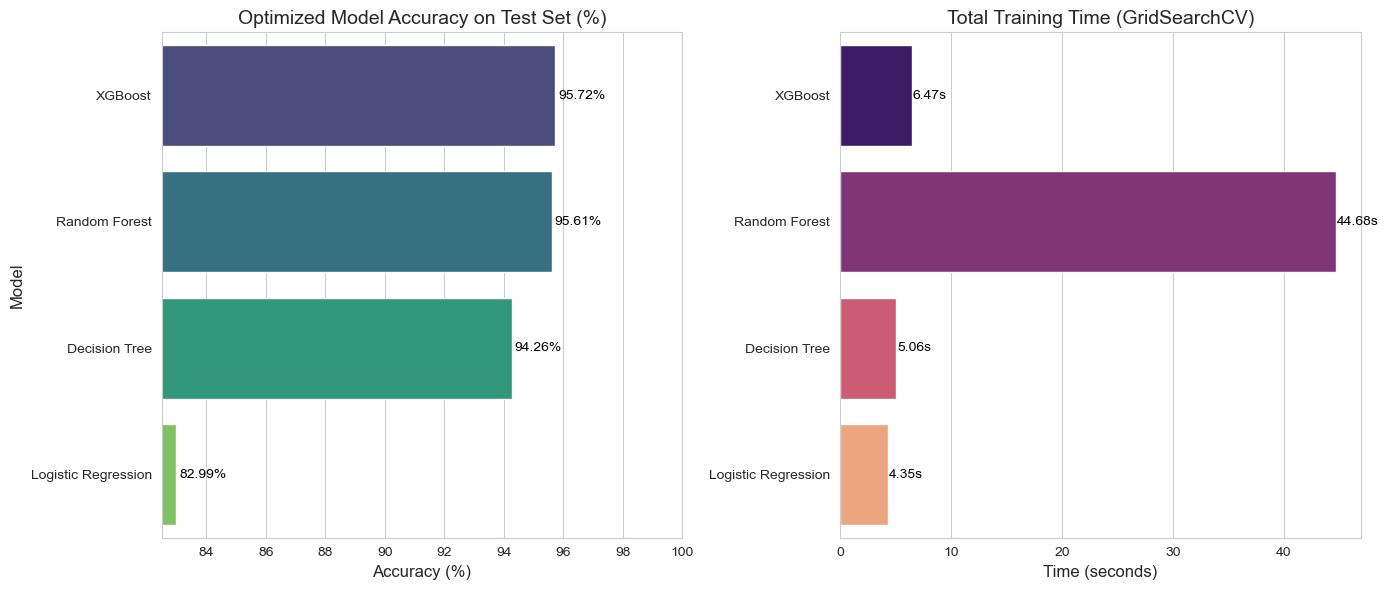

In [125]:
# --- 7. Comparative Results and Performance Plots ---
print("\n--- 7. Optimized Model Comparison Summary ---")

results_df = pd.DataFrame(results).sort_values(by='Test_Accuracy', ascending=False).reset_index(drop=True)
results_df['Test_Accuracy_Percent'] = (results_df['Test_Accuracy'] * 100).round(2)

print(f"\nThe Overall Best Model is: {best_model_name}")
print("\nOptimized Models Comparison Table:")
print(results_df[['Model', 'Test_Accuracy_Percent', 'Training_Time_(s)', 'Best_Params']].to_string(index=False))


# --- 7.1 Plotting: Accuracy and Time Comparison ---
plt.figure(figsize=(14, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
sns.barplot(x='Test_Accuracy_Percent', y='Model', data=results_df, palette='viridis')
plt.title('Optimized Model Accuracy on Test Set (%)', fontsize=14)
plt.xlabel('Accuracy (%)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(min(results_df['Test_Accuracy_Percent'].min() - 0.5, 90), 100)
for index, row in results_df.iterrows():
    plt.text(row['Test_Accuracy_Percent'] + 0.1, index, f"{row['Test_Accuracy_Percent']:.2f}%", color='black', ha="left", va="center")


# Training Time Plot
plt.subplot(1, 2, 2)
sns.barplot(x='Training_Time_(s)', y='Model', data=results_df, palette='magma')
plt.title("Total Training Time (GridSearchCV)", fontsize=14)
plt.xlabel("Time (seconds)", fontsize=12)
plt.ylabel('', fontsize=12) 
for index, row in results_df.iterrows():
    plt.text(row['Training_Time_(s)'] + 0.1, index, f"{row['Training_Time_(s)']:.2f}s", color='black', ha="left", va="center")

plt.tight_layout()
plt.show()


--- 8. Comparaison des Importances de Caractéristiques (Tous les Modèles) ---


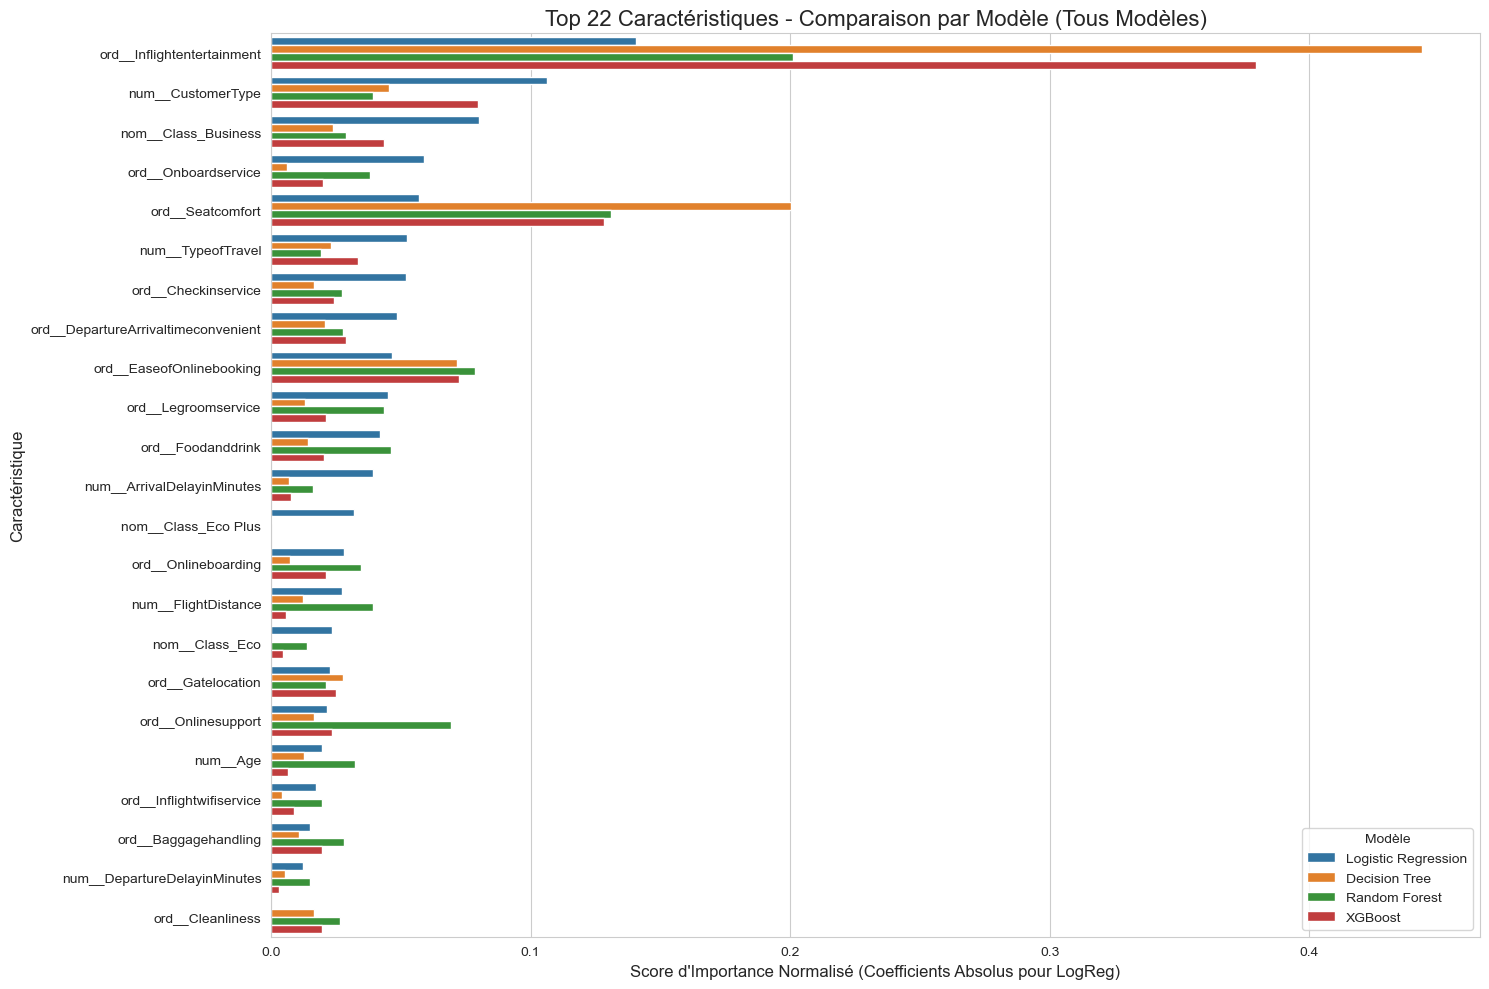


Tableau des 22 premières importances pour tous les modèles normalisés:
Model                                Decision Tree  Logistic Regression  Random Forest  XGBoost
Feature                                                                                        
ord__Inflightentertainment                  0.4437               0.1407         0.2013   0.3797
num__CustomerType                           0.0456               0.1065         0.0393   0.0796
nom__Class_Business                         0.0237               0.0803         0.0290   0.0435
ord__Onboardservice                         0.0063               0.0588         0.0380   0.0200
ord__Seatcomfort                            0.2005               0.0570         0.1309   0.1283
num__TypeofTravel                           0.0229               0.0523         0.0193   0.0335
ord__Checkinservice                         0.0164               0.0522         0.0274   0.0242
ord__DepartureArrivaltimeconvenient         0.0209              

In [126]:
# --- 8. Comparaison de l'Importance des Caractéristiques (tous les 4 modèles) ---
print("\n--- 8. Comparaison des Importances de Caractéristiques (Tous les Modèles) ---")

importance_data = []
# Inclusion de la Régression Logistique
feature_models = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost']
n_top_features = len(df.columns) # Afficher le top 10 pour une meilleure lisibilité

# Récupérer les noms des caractéristiques après prétraitement (nécessaire pour la Régression Logistique)
preprocessor_step = overall_best_estimator.named_steps['preprocessor']
try:
    feature_names_out = preprocessor_step.get_feature_names_out()
except Exception:
    print("Avertissement: Impossible de récupérer les noms de caractéristiques détaillés. Utilisation d'indices génériques.")
    feature_names_out = [f'feature_{i}' for i in range(X_train.shape[1] * 2)] 

# 8.1 Extraction des importances/coefficients
for name in feature_models:
    estimator = trained_estimators.get(name)
    
    if name == 'Logistic Regression':
        classifier = estimator.named_steps['classifier']
        if hasattr(classifier, 'coef_'):
            # Coefficients absolus pour mesurer l'importance pour la Régression Logistique
            # [0] car c'est une classification binaire (une seule ligne de coefficients)
            importances = np.abs(classifier.coef_[0])
        else:
            continue
    elif hasattr(estimator.named_steps['classifier'], 'feature_importances_'):
        # Importance des caractéristiques pour les modèles basés sur les arbres
        importances = estimator.named_steps['classifier'].feature_importances_
    else:
        continue

    # Assurer que les noms de caractéristiques correspondent à la longueur du tableau d'importances
    valid_feature_names = feature_names_out[:len(importances)]
    
    feature_importance_df = pd.Series(importances, index=valid_feature_names)
    
    # Normalisation pour la comparaison (somme = 1 pour chaque modèle)
    feature_importance_normalized = feature_importance_df / feature_importance_df.sum()
    
    # Extraction du Top N
    top_n = feature_importance_normalized.sort_values(ascending=False).head(n_top_features)

    for feature, importance in top_n.items():
        importance_data.append({
            'Model': name,
            'Feature': feature,
            'Importance': importance
        })

importance_df = pd.DataFrame(importance_data)

if not importance_df.empty:
    # 8.2 Tracé comparatif
    plt.figure(figsize=(15, 10))
    # Utilisation d'un graphique à barres horizontal pour comparer facilement les modèles
    sns.barplot(x='Importance', y='Feature', hue='Model', data=importance_df, palette='tab10')
    plt.title(f'Top {n_top_features} Caractéristiques - Comparaison par Modèle (Tous Modèles)', fontsize=16)
    plt.xlabel("Score d'Importance Normalisé (Coefficients Absolus pour LogReg)", fontsize=12)
    plt.ylabel("Caractéristique", fontsize=12)
    plt.legend(title='Modèle')
    plt.tight_layout()
    plt.show()
    
    print(f"\nTableau des {n_top_features} premières importances pour tous les modèles normalisés:")
    # Affichage tabulaire des résultats
    print(importance_df.pivot_table(index='Feature', columns='Model', values='Importance').fillna(0).sort_values(by=feature_models, ascending=False).head(n_top_features).to_string(float_format="{:.4f}".format))

else:
    print("Aucune importance de caractéristique trouvée pour les modèles comparés.")

print("\nAnalyse complète avec optimisation des hyperparamètres et visualisation des résultats terminée.")